In [ ]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import torch
import optuna
import pyreadr
from pathlib import Path
import yaml
from glob import glob
from lightning import LightningModule

from models.temporal_nets import LSTM

In [2]:
def read_rds(path: str | os.PathLike) -> pd.DataFrame:
    return pyreadr.read_r(path)[None]

In [3]:
study_dict = {}

for path in glob('/net/argon/landclim/kraftb/machflow_engression/runs_timesplit/*/xval/optuna.db'):
    study = optuna.load_study(
        study_name='LSTM',
        storage=f'sqlite:///{path}')
    study_dict[path] = study.best_trial.values[0]

In [4]:
best_idx = np.argmin(list(study_dict.values()))
best_path = list(study_dict.keys())[best_idx]
best_checkpoint_path = best_path.replace('optuna.db', 'fold_000/checkpoints/best.ckpt')

In [5]:
lstm = LSTM.load_from_checkpoint(best_checkpoint_path, map_location='cpu')

In [6]:
with open('/net/argon/landclim/kraftb/machflow/runs/staticall_allbasins_sqrttrans/LSTM/xval/fold_000/config.yaml', 'r') as f:
    config = yaml.safe_load(f)
    
ds = xr.open_zarr('/net/argon/landclim/kraftb/machflow/data/harmonized_basins.zarr')
df = read_rds('/net/argon/landclim/kraftb/machflow_engression/drought_operational/20240429/forecast/forecast_extract.rds')
df.date = pd.to_datetime(df.date)
df['Q'] = np.nan

In [233]:
class ProductionWrapper(LightningModule):
    def __init__(self, model: LightningModule, ds: xr.Dataset):
        super().__init__()
        self.model = model

    def forward(self, x, s):

        return self.model(x, s, tau=None)

def save_model(
        dir: str | Path,
        config: dict,
        ds: xr.Dataset,
        model: LightningModule,
        seq_len: int = 46 + 365):

    model_path = os.path.join(dir, 'model.onnx')
    data_path = os.path.join(dir, 'data.nc')
    config_path = os.path.join(dir, 'config.yaml')

    with open(config_path, 'w') as f:
        yaml.dump(config, f)

    static_features = config['data']['init_args']['stat_features']
    dynamic_features = config['data']['init_args']['features']
    ds_stat = ds[static_features]
    if os.path.exists(data_path):
        os.remove(data_path)
    ds_stat.to_netcdf(data_path, 'w')

    wrapper = ProductionWrapper(model, ds)
    wrapper.eval()

    input_sample = {
        'x': torch.randn((87, len(dynamic_features), seq_len)),
        's': torch.randn((87, len(static_features))),
    }
    wrapper.to_onnx(model_path, input_sample, export_params=True)

import onnxruntime

def run_model(
        dir: str | Path,
        meteo_historic: str | Path,
        meteo_forecast: str | Path,
        forecast_length: int = 46,
        temp_context_length: int = 365,
        n_samples: int = 50):
    model_path = os.path.join(dir, 'model.onnx')
    data_path = os.path.join(dir, 'data.nc')
    config_path = os.path.join(dir, 'config.yaml')

    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)
    static_features = config['data']['init_args']['stat_features']
    dynamic_features = config['data']['init_args']['features']

    historic = read_rds(meteo_historic)
    forecast = read_rds(meteo_forecast)

    # Filter the dataframe to only include rows where the date is before '2024-06-13'
    # Temporary workaround, remove when the data is fixed.
    historic = historic[historic.date.astype('datetime64[ns]') < pd.Timestamp(forecast.date.iloc[0])]
    historic['source'] = 'historic'

    historic_single_station = historic[historic.mach_ID == historic.mach_ID.unique()[0]]
    actual_historic_length = len(historic_single_station)

    if actual_historic_length < temp_context_length:
        raise ValueError(
            f'Historic length {actual_historic_length} is shorter than temp_context_length {temp_context_length}.')

    # Cut to temporal context length
    historic = historic[historic.date > historic_single_station.date.iloc[-temp_context_length-1]]

    ids = forecast.mach_ID.sort_values().unique()

    ds = xr.open_dataset(data_path)

    s = ds.sel(station=ids)[static_features].to_array('variable').transpose('station', ...).values.astype('float32')

    ort_session = onnxruntime.InferenceSession(model_path)

    df_pred = []

    for member in  forecast.member.unique():
        forecast_member = forecast[forecast.member == member]

        actual_forecast_length = len(forecast_member[forecast_member.mach_ID == forecast_member.mach_ID.unique()[0]])
        if actual_forecast_length != forecast_length:
            raise ValueError(
                f'Forecast length {actual_forecast_length} does not match expected length {forecast_length}.')

        combined_member = pd.concat([historic, forecast_member]).sort_values(['mach_ID', 'date'])
        combined_member['Q'] = np.nan
        combined_member.loc[combined_member.member.isnull(), 'member'] = member

        x_df = combined_member.groupby('mach_ID')[dynamic_features].apply(
            lambda x: x.to_numpy().astype('float32'))[ids]

        x = np.stack(
                x_df, axis=0
            ).transpose((0, 2, 1))

        onnxruntime_input = {
            input_arg.name: input_value for input_arg, input_value in zip(ort_session.get_inputs(), [x, s])
        }

        preds = []
        for _ in range(n_samples):
            pred = ort_session.run(None, onnxruntime_input)[0][:, 0, :]
            preds.append(pred)
        preds = np.quantile(np.stack(preds, 0), 0.5, axis=0)

        combined_member['Q'] = preds.flatten()

        combined_member.date = pd.to_datetime(combined_member.date)

        df_pred.append(combined_member)

    return pd.concat(df_pred)


In [234]:
with open('/net/argon/landclim/kraftb/machflow/runs/staticall_allbasins_sqrttrans/LSTM/xval/fold_000/config.yaml', 'r') as f:
    config = yaml.safe_load(f)
    
ds = xr.open_zarr('/net/argon/landclim/kraftb/machflow/data/harmonized_basins.zarr')

In [236]:
save_path = Path('./lstm_dir/')
save_path.mkdir(exist_ok=True, parents=True)
save_model(save_path, config=config, ds=ds, model=lstm)

/home/kraftb/.conda/envs/engression/lib/python3.10/site-packages/torch/onnx/symbolic_opset9.py:4661: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(


In [237]:
df = run_model(
    dir='./lstm_dir/',
    meteo_historic='/net/argon/landclim/kraftb/machflow_engression/drought_operational/20240429/forecast/historic_data_3.rds',
    meteo_forecast='/net/argon/landclim/kraftb/machflow_engression/drought_operational/20240429/forecast/forecast_extract.rds')

Text(0.5, 1.0, 'CHFO-0251')

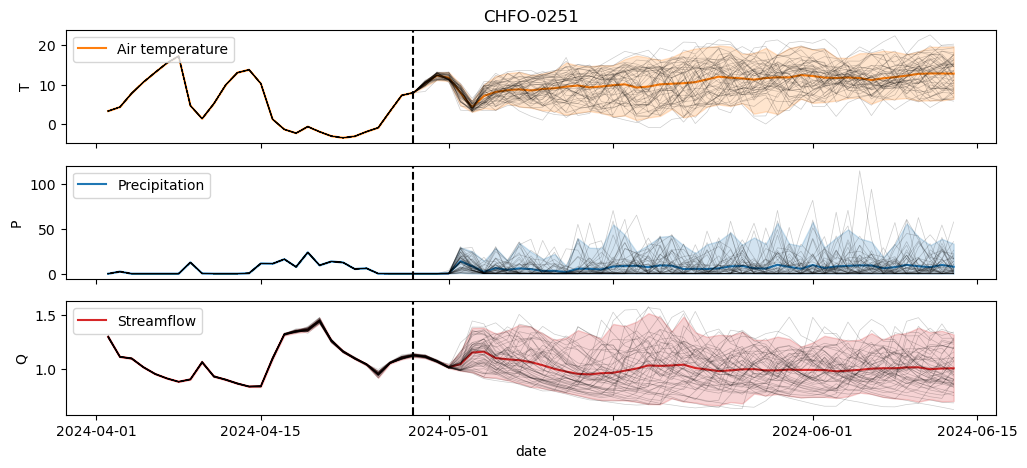

In [238]:
fig, ax = plt.subplots(3, 1, figsize=(12, 5), sharex=True)
s = 'CHFO-0251'
palette = sns.color_palette(['0.'], len(df['member'].unique()))

df_sel = df[(df.date > '2024-04') & (df.mach_ID == s)]

for i, (name, var, col) in enumerate(zip(['Air temperature', 'Precipitation', 'Streamflow'],
                          ['T', 'P', 'Q'],
                          ['tab:orange', 'tab:blue', 'tab:red'])):

    sns.lineplot(
        df_sel,
        x='date',
        y=var,
        color=col,
        errorbar='pi',
        label=name,
        ax=ax[i])
    sns.lineplot(
        df_sel,
        x='date',
        y=var,
        hue='member',
        errorbar='pi',
        legend=False,
        palette=palette,
        lw=0.5,
        alpha=0.2,
        ax=ax[i])
    sns.move_legend(ax[i], 'upper left')

    ax[i].axvline(df_sel[df_sel.source=='historic'].date.iloc[-1], color='k', ls='--')

ax[0].set_title(s)


Text(0.5, 1.0, 'CHFO-0251')

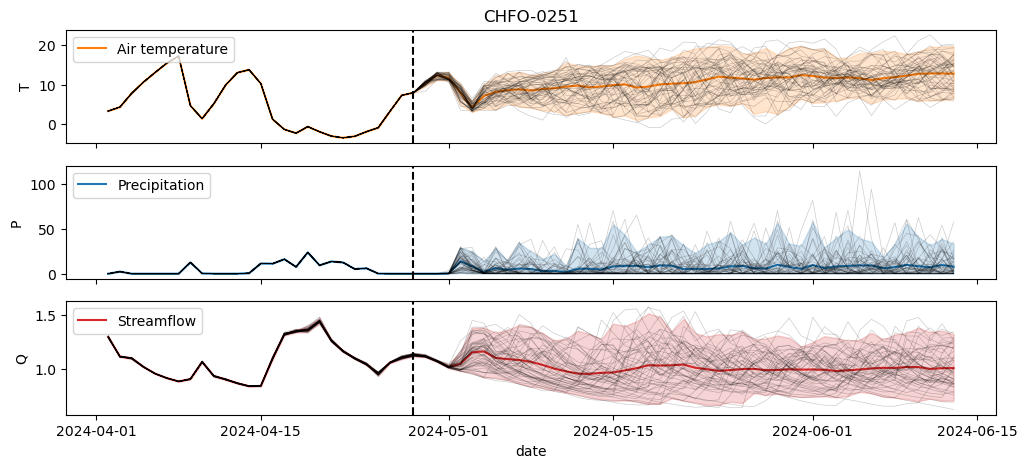

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(12, 5), sharex=True)
s = 'CHFO-0251'
palette = sns.color_palette(['0.'], len(df['member'].unique()))

df_sel = df[(df.date > '2024-04') & (df.mach_ID == s)]

for i, (name, var, col) in enumerate(zip(['Air temperature', 'Precipitation', 'Streamflow'],
                          ['T', 'P', 'Q'],
                          ['tab:orange', 'tab:blue', 'tab:red'])):

    sns.lineplot(
        df_sel,
        x='date',
        y=var,
        color=col,
        errorbar='pi',
        label=name,
        ax=ax[i])
    sns.lineplot(
        df_sel,
        x='date',
        y=var,
        hue='member',
        errorbar='pi',
        legend=False,
        palette=palette,
        lw=0.5,
        alpha=0.2,
        ax=ax[i])
    sns.move_legend(ax[i], 'upper left')

    ax[i].axvline(df_sel[df_sel.source=='historic'].date.iloc[-1], color='k', ls='--')

ax[0].set_title(s)


In [213]:
len(forecast[(forecast.member=='ctr') & (forecast.mach_ID==s)])

46

In [226]:
temp_context_length = 365

In [ ]:
historic_single_station = historic[historic.mach_ID == historic.mach_ID.unique()[0]]
actual_historic_length = len(historic_single_station)
historic[historic.date > historic_single_station.date.iloc[-temp_context_length-1]]

In [223]:
actual_historic_length

1579

,mach_ID,date,P,T,E
1214,CHAG-0001,2023-04-29,0.680000,14.520000,2.905877
1215,CHAG-0001,2023-04-30,9.030000,12.070000,2.556646
1216,CHAG-0001,2023-05-01,5.532354,10.820795,2.383689
1217,CHAG-0001,2023-05-02,3.876866,10.855125,2.402811
1218,CHAG-0001,2023-05-03,0.000000,11.818589,2.563381
...,...,...,...,...,...
137540,CHZH-0042,2024-04-24,0.430000,3.360000,1.210000
137541,CHZH-0042,2024-04-25,0.100000,4.380000,1.370000
137542,CHZH-0042,2024-04-26,0.000000,7.650000,1.860000
137543,CHZH-0042,2024-04-27,0.000000,12.140000,2.540000
